Compute the time evolution of a 2 ion system contructed to simulate electron transfer. @author: zhumj

Reproduce the result in Schlawin et. al. PRXQuantum Paper:
https://journals.aps.org/prxquantum/abstract/10.1103/PRXQuantum.2.010314


In [8]:
import numpy as np
from qutip import *
import matplotlib.pyplot as plt
import Qsim.operator.spin as spin
import Qsim.operator.phonon as phon
import Qsim.ion_chain.transfer.elec_transfer as etrans
from  Qsim.ion_chain.ion_system import *
import Qsim.operator.spin_phonon as sp_op
import Qsim.ion_chain.interaction.dissipation as disp
import Qsim.auxiliay_function.data_fitting as fit
plt.rcParams['figure.dpi']= 200

In [3]:
#%%
'''
parameters of the system, use the same parameter in quantum regime 
'''    
delta = 20 #detuning from com mode
ion_sys = ions(trap_config = {'N':2,'fx':2,'fz':1}) #construct a two ion system using class ions
ion_sys.coolant = [1] #ion 2 as coolant
ion_sys.active_phonon = [[0]] #consider only com mode
ion_sys.active_spin = [0]
ion_sys.pcut = [[20]]
ion_sys.update_all(print_text = False)

Trap coefficients updated
Anharmonic coefficients updated
_____________________________________________________________
Checking phonon space setup
Phonon space setups are consistent
_____________________________________________________________
Phonon space parameters updated
Cooling parameters updated
Trap parametric modulation updated
Ions class object initialized.


In [4]:
laser1 = Laser()
laser1.Omega_eff = 70
laser1.wavevector = 1 
laser1.laser_couple = [0]
laser1.mu = 1e3*ion_sys.fx-delta
laser1.list_para()

Laser parameters updated
Lasers class object initialized.
                                                                 
********************Parameters of Laser Drive************************
Vibrational degree of freedom couples to the laser: Transverse (Radial x)
index of ions that couple to the laser field:  [0]
Effective rabi frequency  70  [kHz]
Effective laser frequency  1980.0  [kHz]
Laser phase phis 0.0
(input in rad but displayed in degs)


In [5]:
omegax = 0.01*np.abs(delta)*2
omegay = 0.01*np.abs(delta)*0
deltaE = 5*np.abs(delta)  #note site energy difference is negative by definition 
n0=2
df_p = 1 #for phonon measurements
'''
simulation with 1 mode, reproduce curve C in Fig 3(B)
'''
elist = [sp_op.spin_measure(ion_sys,[0,1]),
         sp_op.phonon_measure(ion_sys,df_p, mindex=1)#tilt mode population
]
#solve time evolution for a single energy splitting
H0  = etrans.H_res(ion_sys,laser1, Omegax=omegax,Omegay=omegay,Omegaz=deltaE,i_type=0)#i_type=0->zz, i_type=1->laser phase (0 for x, pi/2 for y)
clist1 = disp.cooling(ion_sys,gamma_list = [0.05*np.abs(delta)/(2*np.pi),0],
                      nbar_list = [0.01],df=1, normalized = False)
rho0 = sp_op.rho_thermal(ion_sys, nbar_list=[[0.01]],s_state=[0],ket = False)
tplot = np.arange(0,200,0.1)
times = tplot*2*np.pi/(2*np.pi*np.abs(delta))
print("solving time evolution (1 mode) for deltaE =", deltaE)
result = mesolve(H0,rho0,times,clist1,elist,progress_bar=True,options=Options(nsteps=100000))

solving time evolution (1 mode) for deltaE = 100
10.0%. Run time:   0.73s. Est. time left: 00:00:00:06
20.0%. Run time:   1.51s. Est. time left: 00:00:00:06
30.0%. Run time:   2.27s. Est. time left: 00:00:00:05
40.0%. Run time:   3.03s. Est. time left: 00:00:00:04
50.0%. Run time:   3.79s. Est. time left: 00:00:00:03
60.0%. Run time:   4.52s. Est. time left: 00:00:00:03
70.0%. Run time:   5.24s. Est. time left: 00:00:00:02
80.0%. Run time:   5.98s. Est. time left: 00:00:00:01
90.0%. Run time:   6.69s. Est. time left: 00:00:00:00
Total run time:   7.42s


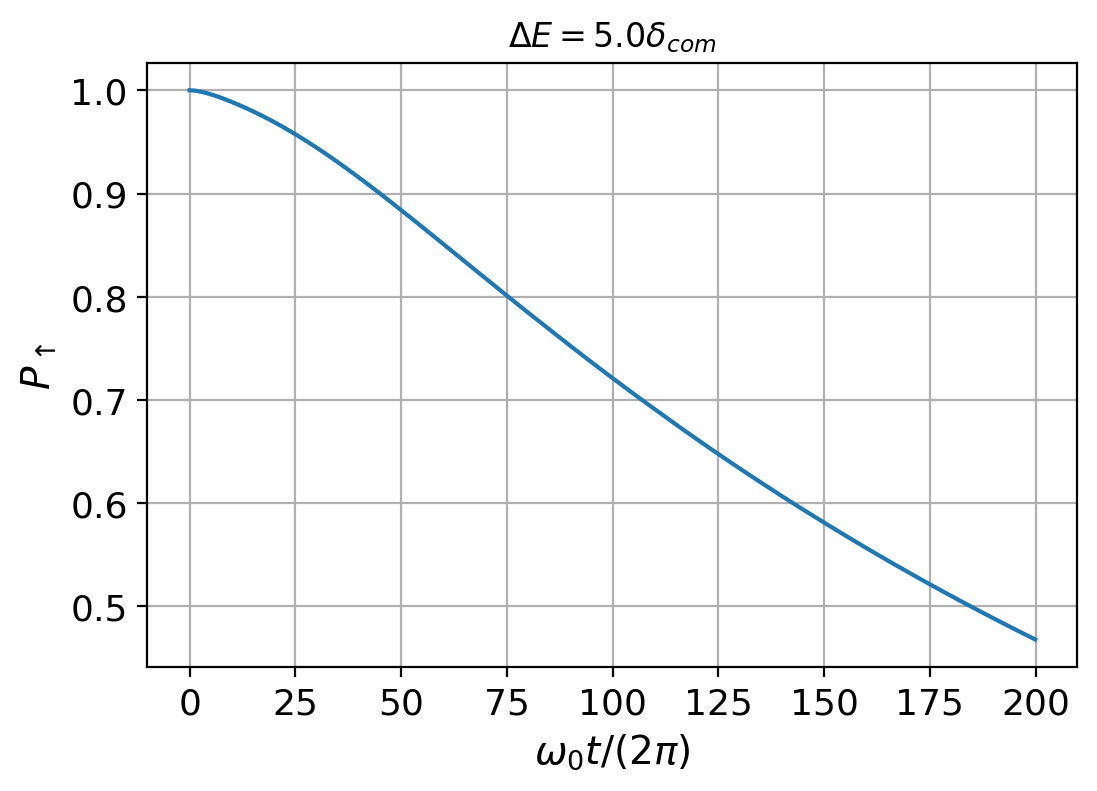

In [6]:
#%%
#extract ground state population
rhoee1 = result.expect[0]
plt.clf()
plt.plot(tplot,rhoee1)
title = r'$\Delta E = $' + str(deltaE/delta)+r'$\delta_{com}$'
plt.xlabel(r'$\omega_0t/(2\pi)$',fontsize = 14)
plt.ylabel(r'$P_{\uparrow}$',fontsize = 14)
plt.title(title)
plt.grid()   
plt.yticks(fontsize = 13)
plt.xticks(fontsize = 13)
plt.show()

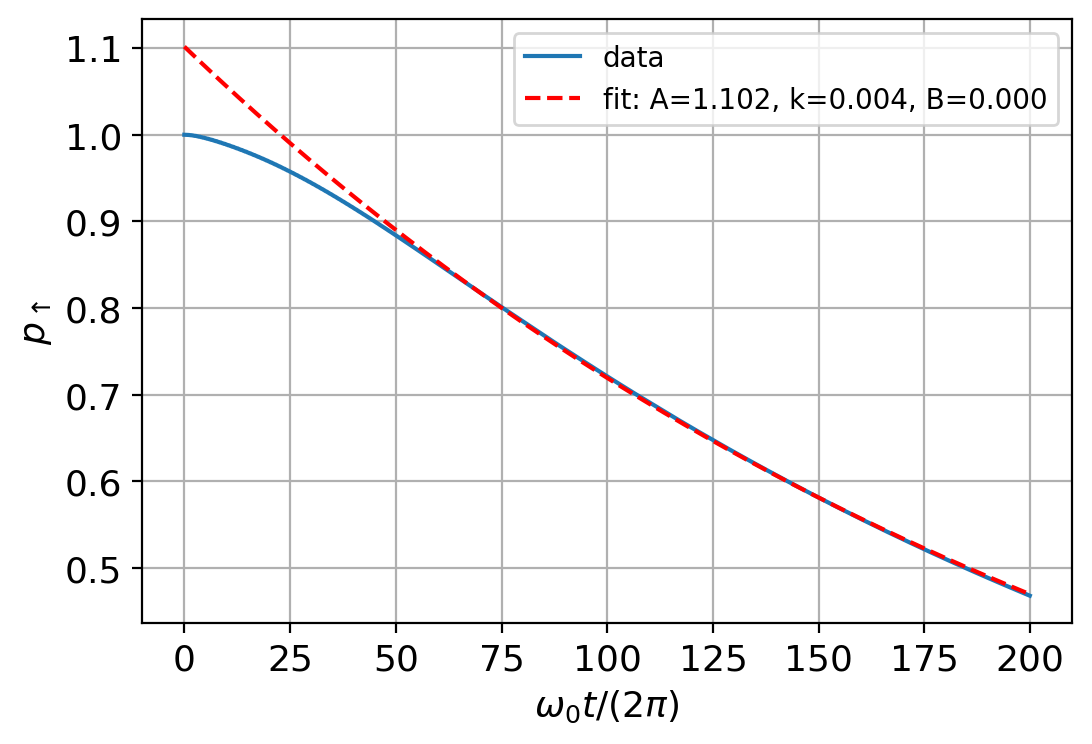

estimated decay rate, [1/omega0] 0.0006785163606137236


In [13]:
#%% fit data from t= 50-200 
d_rate = fit.fit_et_decay(tplot,rhoee1,fit_interval=[500,2000],plot=True,all_parameter=False)
print('estimated decay rate, [1/omega0]', d_rate/(2*np.pi))
#note that in the paper the decay rate is defined with unit 1/omega0 but the decay rate from fitting has 
#unit of 2pi/omega